<a href="https://colab.research.google.com/github/kenichinakanishi/houseplant_classifier/blob/master/Part_4_PyTorchCV_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
# Check GPU on Colabs
# NVIDIA-SMI 455.32.00 Driver Version: 418.67 CUDA Version: 10.1 Tesla V100-SXM2
! nvidia-smi 

Mon Nov 30 23:50:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Run once per session
!pip install fastai==2.1.2 -q
!pip install fastcore==1.3.1 -q
!pip install torch==1.7.0 -q
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.callback.cutmix import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastcore.script import *
fastprogress.MAX_COLS = 80

     |████████████████████████████████| 194kB 13.3MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 


In [4]:
torch.cuda.is_available()

True

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil -q
!pip install psutil -q
!pip install humanize -q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [ ]:
printm()

# Download and Unzip the File

The use of images directly from a google drive is very slow.
This is because even though the drive appears to be direcly attached to our colab instance, in actuality we are dynamically downloading and accessing each image one by one - leading to extremely long training times. 

At this point, I've gone to the directory the image files were downloaded to, zipped them up and placed that master zip file into my google drive for importing and processing. 

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database_manualcleanedlosses10.zip' 'plant_images_database_manualcleanedlosses10.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database_manualcleanedlosses10.zip" -d "/content";

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database.zip' 'plant_images_database.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database.zip" -d "/content";

# Set Up Model

In [ ]:
def random_seed(seed_value, use_cuda):
  '''
  Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.
  '''
  np.random.seed(seed_value) # Numpy vars
  torch.manual_seed(seed_value) # PyTorch vars
  random.seed(seed_value) # Python
  if use_cuda: # GPU vars
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) 
      torch.backends.cudnn.deterministic = True 
      torch.backends.cudnn.benchmark = False
  print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

In [ ]:
@call_parse
def create_path_df(
      path: Param("Path of images to use", str), 
      pct_images: Param("Fraction of images to use", float)=1,
      shuffle: Param("Shuffle prior to splitting", bool)=False,
      ):
  '''
  Creates a dataframe with respective classes and path to images.
  Can return a subset of those images based on the pct_images.
  By default will return the earliest files in the path.

  Returns:
  ----------
  DataFrame
    Returns a dataframe with Class and Path columns. 
  '''
  from sklearn.utils import shuffle as shuff
  data = []
  for folder in sorted(os.listdir(path)):
      num_files = len(sorted(os.listdir(path+'/'+folder)))
      cut_point = int(num_files*pct_images)
      # Takes the first pct_images from each folder
      if shuffle == True:
        for file in shuff(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
      else:
        for file in sorted(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
  df = pd.DataFrame(data, columns=['Class', 'Path'])
  print(f'Creating path:label dataframe from {path}, using {pct_images*100:.2f}% of the images ({len(df)} images.) Shuffle = {shuffle}.')
  return df

In [ ]:
@call_parse
def stratified_split(
      dataframe: Param("DataFrame created from create_path_df, containing Class and Path columns."), 
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      random_state: Param("Fix randomness if shuffle==True", int)=101,
      ):
  ''' 
  Prepares a stratified k-fold split from a dataframe with 'Class' and 'Path' by adding an 'is_valid' column.

  Returns:
  ----------
  DataFrame
    Returns the requested stratified k-fold split by adding an 'is_valid' column. 
  '''
  from sklearn.model_selection import StratifiedKFold
  # Create stratified split using sklearn
  print(f'Preparing stratified {n_splits} fold split, random state is {random_state}. Returning fold {fold}.')
  kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state = random_state)
  X, y = dataframe['Path'], dataframe['Class']
  splits = list(kf.split(X, y))
  # Prepare the selected fold
  fold = fold
  train_df = dataframe.loc[splits[fold][0]]
  val_df = dataframe.loc[splits[fold][1]]
  train_df['is_valid'] = False
  val_df['is_valid'] = True
  df_cnn = train_df.append(val_df)
  # Return the selected fold
  return df_cnn

In [ ]:
@call_parse
def get_dataloader(
      img_path: Param("Path of images to use", str),
      split_path: Param("Path of images to use to pre-define split", str)=None,
      img_size:  Param("Size in pixels", int)=224,
      pct_images: Param("Fraction of images to use", float)=1,
      bs: Param("Batch size", int)=64,
      deterministic: Param("Deterministic learner", bool)=True,
      randomerasing: Param("Random Erasing", str)=None,
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      ):
  """ 
  Takes in image path and creates a dataloader. 
  If a split_path is defined, uses the entirety of that path to generate a master split, onto which the img_path is joined to defined a pseudo split.  
      
  Returns:
  ----------
  Dataloader
    dls = data.dataloaders(df_cnn_mini, bs=bs)
  """

  # Get file path and labels from the dataframe we set up.
  get_x = lambda x: x['Path']
  get_y = lambda y: y['Class']
  # Define splitting function that reads from a dataframe column.
  def stratifiedsplitter(df):      
      train = df.index[~df['is_valid']].tolist()
      valid = df.index[df['is_valid']].tolist()
      return train,valid   
  # Prepare transforms
    # Image is larger initially (512 px) for later augmentations.
  item_tfms=[RandomResizedCrop(512, min_scale = 0.7)]
    # Batch transformations include a random resized crop to img_size px. 
  batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
  # Add in randomerasing if necessary.
  if randomerasing != None:
    batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats), randomerasing]
  # Prepare DataBlock
  data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=stratifiedsplitter,            # Stratified train/validation split
                    get_x=get_x,                            # Get the image path from dataframe
                    get_y=get_y,                            # Label from dataframe
                    item_tfms=item_tfms,                    # Crop images to a square
                    batch_tfms=batch_tfms)                  # Normalize the images based on the imagenet stats
  if split_path != None:
    print('Split Path defined, preparing pseudo stratified split.')
    # Create split_df - a dataframe that defines a master split, based on split_path
    df = create_path_df(split_path, pct_images=1)
    split_df = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
    split_df['Path']= split_df['Path'].apply(lambda x:img_path+'/'.join(x.split('/')[-2:]))
    # Inner join this reduced dataframe to the previous splits to maintain the same training images
    df_mini = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini= df_mini.merge(split_df, how = 'inner', on = ['Class','Path'])
  else: 
    # Create a dataframe based on main image path with a (possibly) reduced number of images
    df = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
  # Print some information for a sanity check
  dls = data.dataloaders(df_cnn_mini, bs=bs)
  print(f'We have {dls.c} classes, with a training set of size {len(dls.train_ds)}, and a validation set of size {len(dls.valid_ds)}')
  if split_path != None:
    print(f"The main split has {split_df['is_valid'].describe()['freq']/len(split_df['is_valid'])*100:.2f}% training data with {len(split_df.groupby('Class').count())} classes, the reduced split has {df_cnn_mini['is_valid'].describe()['freq']/len(df_cnn_mini['is_valid'])*100:.2f} % training data, with {len(df_cnn_mini.groupby('Class').count())} classes.")
  return dls

In [ ]:
@call_parse
def create_simple_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        arch:  Param("Architecture", str)='resnet34',
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        ):
    # Select optimization function
    opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    # Set Random Seed
    if deterministic == True:
      random_seed(101,True)
    # Get Dataloader
    dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [ ]:
@call_parse
def create_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='adam',
        arch:  Param("Architecture", str)='resnet34',
        custom_head:  Param("Use of custom head", nn.Sequential)=None,
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        sa: Param("Self Attention for XResNet", bool)=False,
        act_cls: Param("Activation class to use", str)='ReLU',
        loss_func: Param("Learner loss function", str)=None,
        mixup: Param("Mixup", str)=None,
        cutmix: Param("Cutmix", str)=None,
        randomerasing: Param("Random Erasing", str)=None,
        ):
    # Select optimization function
    if   opt=='adam'  : opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=0.99, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='ranger': opt_func = partial(ranger, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)
    # Get DataLoader
    if deterministic == True:
      random_seed(101,True)
    # Implement RandomErasing
    if randomerasing != None:
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images, randomerasing=randomerasing)
    else: 
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    if ('xresnet' in arch) and act_cls != 'ReLU':
      model = partial(model, act_cls=act_cls, sa=sa, n_out=dls.c)
    elif 'xresnet' in arch:
      model = partial(model, sa=sa, n_out=dls.c)
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    if mixup != None:
      mixup = mixup
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), mixup]
    elif cutmix != None:
      cutmix = cutmix
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), cutmix]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        config = {'custom_head':custom_head},
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        loss_func = loss_func,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [ ]:
def enumerate_params(learner):
  '''
  Enumerates the unfrozen and frozen parameters for a given learner when called.
  '''
  total_params = sum(p.numel() for p in learner.model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
  p.numel() for p in learner.model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

# Model Exploration

In [ ]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

# Altering Model Features

In [ ]:
def change_act(model, pretrained, pre_act, post_act):
  model = model(pretrained=pretrained)
  # We want to go down each 'level' of the model and search for each activation, changing them to the activation we want to use.
    # We can access the named_children of the model and use that to index our way into the appropriate layers
    # pre_act is a class
    # EfficientNet - geffnet.activations_me.SwishMe
    # ResNet - torch.nn.modules.activation.ReLU
    # post_act examples - Mish()
  count = 0
  block_list = list(dict(model.named_children()).keys())
  for block in block_list:
    layer0_list = list(dict(model._modules[block].named_children()).keys())
    model._modules[block]
    if isinstance(model._modules[block], pre_act):
      model._modules[block] = post_act
      count += 1
    for layer0 in layer0_list:
      layer1_list = list(dict(model._modules[block]._modules[layer0].named_children()).keys())
      model._modules[block]._modules[layer0]
      if isinstance(model._modules[block]._modules[layer0], pre_act):
        model._modules[block]._modules[layer0] = post_act
        count += 1
      for layer1 in layer1_list:
        layer2_list = list(dict(model._modules[block]._modules[layer0]._modules[layer1].named_children()).keys())
        model._modules[block]._modules[layer0]._modules[layer1]
        if isinstance(model._modules[block]._modules[layer0]._modules[layer1], pre_act):
          model._modules[block]._modules[layer0]._modules[layer1] = post_act
          count += 1
        for layer2 in layer2_list:
          layer3_list = list(dict(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2].named_children()).keys())
          model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]
          if isinstance(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2], pre_act):
            model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2] = post_act
            count += 1
          for layer3 in layer3_list:
            layer4_list = list(dict(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3].named_children()).keys())
            model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3]
            if isinstance(model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3], pre_act):
              model._modules[block]._modules[layer0]._modules[layer1]._modules[layer2]._modules[layer3] = post_act
              count += 1

  print(f'Changing activation function from {pre_act} to {post_act}. {count} instances changed. ')
  return nn.Sequential(*model.children())

In [ ]:
# Each model should be present as a function in the global namespace 
def seresnet50(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
model = seresnet50()

In [ ]:
mish_model = change_act(seresnet50, pretrained=True, pre_act=torch.nn.modules.activation.ReLU, post_act=Mish())

In [ ]:
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2)
  return model

In [ ]:
model = tf_efficientnet_b3()

In [ ]:
mish_model = change_act(tf_efficientnet_b3, pretrained=False, pre_act=geffnet.activations_me.SwishMe, post_act=Mish())

# PyTorchCV

In this library, the model features are encapsulated in features, as a nn.Sequential.

The model head is actually in the .output, so the below code is simply getting the arch sans head

https://github.com/osmr/imgclsmob/tree/master/pytorch

In [ ]:
! pip install pytorchcv torch>=0.4.0 -q
from pytorchcv.model_provider import get_model as ptcv_get_model

In [ ]:
# Each model should be present as a function in the global namespace 
def seresnet50(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
type(seresnet50())

## PyTorchCV Default Head

In [ ]:
# Each model should be present as a function in the global namespace 
def seresnet50(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
arch_summary(seresnet50)

(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
(5) AvgPool2d   : 1   layers (total: 237)


We can further unpack the blocks into the next substructure.  

In [ ]:
for i in range(6):
    print(f'---------({i})---------')
    arch_summary(lambda _: seresnet50()[i])

---------(0)---------
(0) ConvBlock   : 3   layers (total: 3)
(1) MaxPool2d   : 1   layers (total: 4)
---------(1)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
---------(2)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
(3) SEResUnit   : 14  layers (total: 58)
---------(3)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
(3) SEResUnit   : 14  layers (total: 58)
(4) SEResUnit   : 14  layers (total: 72)
(5) SEResUnit   : 14  layers (total: 86)
---------(4)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
---------(5)---------


As we are only extracting the features of the model, there won't be a head to the model - in this case we only see an AvgPool2d layer.

In [ ]:
# Let's look at the current head
# For transfer learning, we can cut out the last two layers and add our own custom head depending on the problem.
list(seresnet50().children())[-1:]

[AvgPool2d(kernel_size=7, stride=1, padding=0)]

## PyTorchCV + Automatic fast.ai head

The cnn_leaner helper function automatically changes the last few layers of the input model. 
Specifically it finds the last pooling layers, and replaces them with AdaptiveConcatPool2d, Flattens it, Adds to linear layers with batch norms and relu, adds dropout, and finally puts an output layer.

The reason for using Adaptive Pooling layers is that it allows the model to use any image size rather than being restricted to a constant size of say 224 x 224. What Adaptive Pooling layer does is it to specify the output size rather than the kernel size.

In fast.ai, the model is cut by default to the first layer that contains some pooling otherwise.



In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def seresnet50(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
# Head is automatically built to be the same. 
# Input to arch_summary must be a function, so let's use a lambda function
arch_summary(lambda _: learn.model)

(0) Sequential  : 236 layers (total: 236)
(1) Sequential  : 10  layers (total: 246)


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

2

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): ResInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (unit1): SEResUnit(
        (body): ResBottleneck(
          (conv1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inp

The cnn_learner helper function by fast.ai does a few things behind the scenes. 

1.   Finds the last pooling layer and cuts the model there to create a body containing most of the features. 
2.   Creates a fast.ai head for vision classification tasks.
3.   Initializes this head with the kaiming normal.
4.   Appends this head to the body. 


## PyTorchCV + Manual Custom Head

We will now write a custom head which we will append in front of the existing model - remove the average pooling, replace it with adaptive concat pooling and add your own linear layer.



In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def seresnet50(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
arch_summary(seresnet50)

(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
(5) AvgPool2d   : 1   layers (total: 237)


In [ ]:
num_features_model(seresnet50())

2048

We need to know the output dimension, this can be done using num_features_model on a headless model, or by looking at the appropriate layer (just prior to the head).



In [ ]:
seresnet50()[-2:]

Sequential(
  (stage4): Sequential(
    (unit1): SEResUnit(
      (body): ResBottleneck(
        (conv1): ConvBlock(
          (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv3): ConvBlock(
          (conv): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (se): SEBlock(
        (pool): AdaptiveAvgPool2d(output_size=1)
        (conv1): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
        (activ): 

In [ ]:
# Manually Build Head
# Due to the use of AdaptiveConcatPool2d, the BatchNorm1D layers need 2* the inputs of the last output layer
custom_head = nn.Sequential(AdaptiveConcatPool2d(), 
                            Flatten(), 
                            nn.BatchNorm1d(4096), 
                            nn.Dropout(p=0.25, inplace=False),
                            nn.Linear(in_features=4096, out_features=512, bias=False), 
                            nn.ReLU(inplace=True),
                            nn.BatchNorm1d(512), 
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=512, out_features=517, bias=False))

# Fast.ai wants each model to be a function in the global namespace that returns a nn.Sequential when called
# Let's add the head then wrap everything as a function
# Fast.ai does this for us automatically when we use the cnn_learner helper function
  # We don't need the below - because fast.ai does it for us!
def seresnet50_customhead(pretrained=True):
    model = nn.Sequential(*list(seresnet50().children())[:-1], custom_head)
    return model

A custom_head parameter is passed to the helper function, as passing a complete model will cause the default cut, head creation and appending to occur. 

In [ ]:
# Create a learner
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           custom_head = custom_head,
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=517, bias=False)
)

## PyTorchCV + Custom Split

We will now write a custom head which we will append in front of the existing model - remove the average pooling, replace it with adaptive concat pooling and add your own linear layer.



In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def se_resnet50_customsplit(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
m = se_resnet50_customsplit
arch_summary(se_resnet50_customsplit)

(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
(5) AvgPool2d   : 1   layers (total: 237)


In [ ]:
for i in range(6):
    print(f'---------({i})---------')
    arch_summary(lambda _: m()[i])

---------(0)---------
(0) ConvBlock   : 3   layers (total: 3)
(1) MaxPool2d   : 1   layers (total: 4)
---------(1)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
---------(2)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
(3) SEResUnit   : 14  layers (total: 58)
---------(3)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
(3) SEResUnit   : 14  layers (total: 58)
(4) SEResUnit   : 14  layers (total: 72)
(5) SEResUnit   : 14  layers (total: 86)
---------(4)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
---------(5)---------


To group the layers for discriminative learning rates, we can set (0) to (2) as group 1, set (3) to (4) as group 2, and the fast.ai head as group 3.

By default, fast.ai assigns index 0 to the model features and index 1 to the head, hence we need a split that looks like the one below. 

In [ ]:
# Recall we want to cut at -2, and split at (2) in the arch_summary, we define
def _se_resnet50_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[se_resnet50_customsplit] = {'cut': -1, 
                           'split': _se_resnet50_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'se_resnet50_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
arch_summary(lambda _: learn.model)

(0) Sequential  : 236 layers (total: 236)
(1) Sequential  : 10  layers (total: 246)


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

3

In [ ]:
# First split should free up around 5% of the training parameters, as per fast.ai default resnet splits.
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
28,410,096 total parameters.
28,410,096 training parameters.
---------1 Groups Frozen--------
28,410,096 total parameters.
26,816,640 training parameters.
---------2 Groups Frozen--------
28,410,096 total parameters.
2,424,192 training parameters.
---------3 Groups Frozen--------
28,410,096 total parameters.
62,336 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


## Exploration

In [ ]:
def seresnet50(pretrained=False):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
arch_summary(seresnet50)

(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
(5) AvgPool2d   : 1   layers (total: 237)


In [ ]:
for i in range(6):
    print(f'---------({i})---------')
    arch_summary(lambda _: seresnet50()[i])

---------(0)---------
(0) ConvBlock   : 3   layers (total: 3)
(1) MaxPool2d   : 1   layers (total: 4)
---------(1)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
---------(2)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
(3) SEResUnit   : 14  layers (total: 58)
---------(3)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
(3) SEResUnit   : 14  layers (total: 58)
(4) SEResUnit   : 14  layers (total: 72)
(5) SEResUnit   : 14  layers (total: 86)
---------(4)---------
(0) SEResUnit   : 16  layers (total: 16)
(1) SEResUnit   : 14  layers (total: 30)
(2) SEResUnit   : 14  layers (total: 44)
---------(5)---------


In [ ]:
seresnet50()[0]

ResInitBlock(
  (conv): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
m = learn.model
# Input to arch_summary must be a function, so let's use a wrap it in a lambda function
  # m must be a torch.nn.modules.container.Sequential
arch_summary(lambda _: m)

(0) Sequential  : 236 layers (total: 236)
(1) Sequential  : 10  layers (total: 246)


## Architectures PyTorchCV

## SE-ResNet

### SE-ResNet10

In [ ]:
def seresnet10(pretrained=False):
    return ptcv_get_model("seresnet10", pretrained=pretrained).features

In [ ]:
seresnet10()

Sequential(
  (init_block): ResInitBlock(
    (conv): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (unit1): SEResUnit(
      (body): ResBlock(
        (conv1): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (se): SEBlock(
        (pool): Adapti

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet10',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
5,742,396 total parameters.
797,824 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

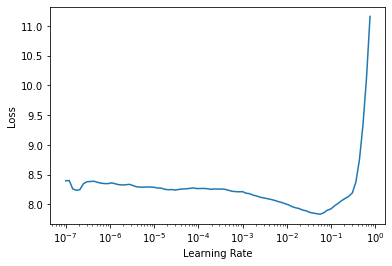

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.626021,4.058927,0.195864,0.410635,00:58
1,4.167397,3.338552,0.281536,0.539439,00:58
2,3.374367,2.890355,0.370162,0.626588,00:57
3,3.001330,2.615199,0.399409,0.673560,01:00
4,2.644510,2.434643,0.435746,0.707238,01:00
5,2.298003,2.271165,0.467356,0.743575,01:00
6,1.970050,2.133683,0.489808,0.764549,01:00
7,1.649849,2.045397,0.514623,0.779321,00:59
8,1.466242,1.998391,0.529985,0.787592,00:59
9,1.277794,1.990981,0.529394,0.786115,01:00


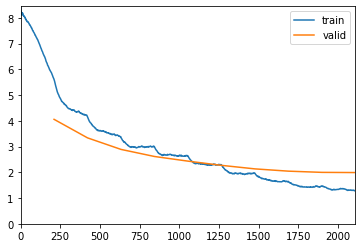

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet10.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet10')

Unfreezing model body
5,742,396 total parameters.
5,742,396 training parameters.


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=7.585775847473997e-07)

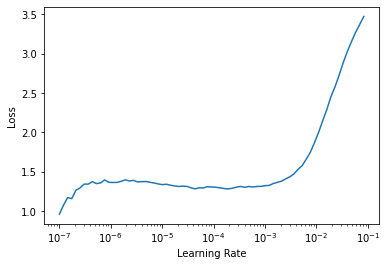

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.317807,1.990622,0.533235,0.783752,01:01
1,1.296874,1.975274,0.531758,0.792319,01:02
2,1.272212,1.958139,0.533530,0.792024,01:01
3,1.223544,1.953426,0.531462,0.795569,01:02
4,1.220007,1.953371,0.534417,0.791137,01:03
5,1.173452,1.934178,0.541802,0.794682,01:02
6,1.152239,1.936258,0.537666,0.794387,01:02
7,1.173113,1.937862,0.538848,0.797046,01:01
8,1.135063,1.932843,0.539143,0.797341,01:02
9,1.142933,1.929782,0.545938,0.796750,01:02


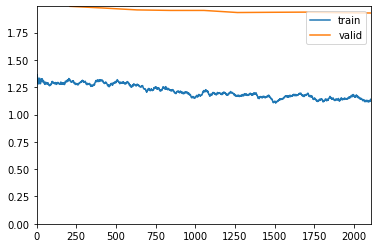

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet10.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet10')

### SE-ResNet18

In [ ]:
def seresnet18(pretrained=False):
    return ptcv_get_model("seresnet18", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet18',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
12,057,656 total parameters.
801,664 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.019054606556892395)

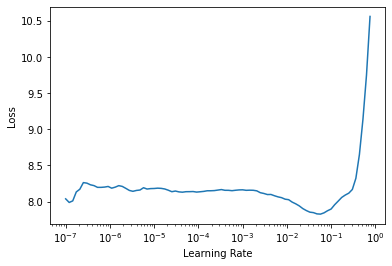

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.864684,4.298381,0.158346,0.373708,01:02
1,4.223738,3.350178,0.280354,0.545643,01:04
2,3.360810,2.890028,0.358936,0.626588,01:04
3,2.943319,2.602775,0.394978,0.684490,01:04
4,2.623469,2.392724,0.436928,0.722895,01:03
5,2.246161,2.245186,0.472969,0.747120,01:04
6,1.943532,2.080746,0.498966,0.774594,01:02
7,1.612874,1.986359,0.524372,0.794682,01:03
8,1.384097,1.948092,0.533235,0.802068,01:03
9,1.285332,1.937290,0.533826,0.805613,01:03


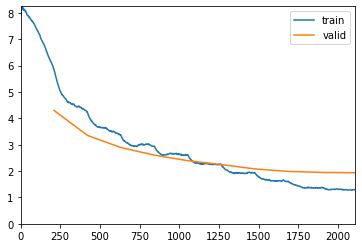

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet18.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet18')

Unfreezing model body
12,057,656 total parameters.
12,057,656 training parameters.


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=7.585775847473997e-07)

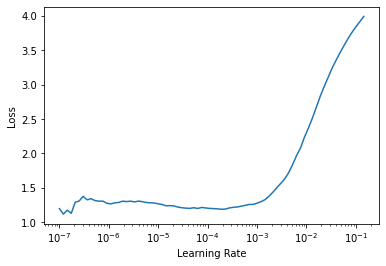

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.273682,1.942195,0.537371,0.805318,01:05
1,1.262955,1.916559,0.537962,0.808863,01:04
2,1.241912,1.889714,0.541507,0.812999,01:05
3,1.192440,1.885141,0.544461,0.811226,01:05
4,1.139899,1.872219,0.543575,0.816544,01:06
5,1.087605,1.853750,0.543575,0.817430,01:04
6,1.048914,1.854267,0.552142,0.818021,01:05
7,1.046615,1.852994,0.551256,0.817430,01:05
8,1.020087,1.852517,0.548892,0.818907,01:05
9,1.024525,1.842224,0.554505,0.820975,01:05


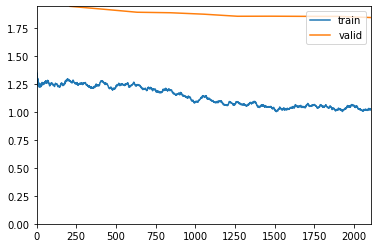

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet18.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet18')

### SE-ResNet26

In [ ]:
def seresnet26(pretrained=False):
    return ptcv_get_model("seresnet26", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet26',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
18,372,916 total parameters.
805,504 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.019054606556892395)

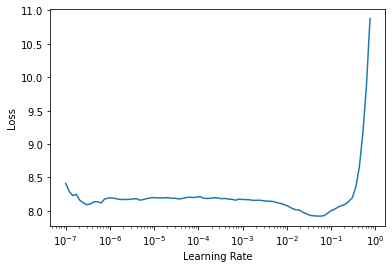

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.085240,4.523647,0.138848,0.329099,01:04
1,4.299865,3.443844,0.265288,0.523191,01:05
2,3.390097,2.858860,0.368981,0.640768,01:05
3,2.930762,2.547136,0.403840,0.691580,01:05
4,2.558420,2.326787,0.449631,0.740620,01:05
5,2.196833,2.139938,0.502511,0.759527,01:05
6,1.877426,1.989386,0.517578,0.785820,01:05
7,1.525164,1.917327,0.537666,0.791728,01:04
8,1.320686,1.879209,0.545347,0.808567,01:05
9,1.184777,1.867874,0.550074,0.809158,01:05


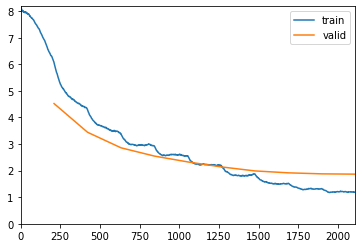

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet26.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet26')

Unfreezing model body
18,372,916 total parameters.
18,372,916 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=7.585775847473997e-07)

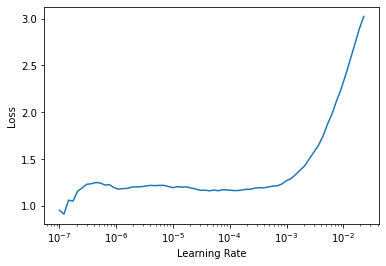

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.198480,1.861682,0.549778,0.808567,01:07
1,1.155406,1.835068,0.561004,0.809158,01:07
2,1.132684,1.814077,0.562186,0.812112,01:07
3,1.102745,1.799281,0.569276,0.815362,01:06
4,1.048829,1.788603,0.569572,0.820975,01:07
5,0.949402,1.774354,0.570753,0.819498,01:07
6,0.923755,1.771950,0.575185,0.821566,01:07
7,0.932709,1.767378,0.573708,0.822747,01:07
8,0.919545,1.767718,0.574594,0.821566,01:06
9,0.879527,1.762827,0.577253,0.824520,01:07


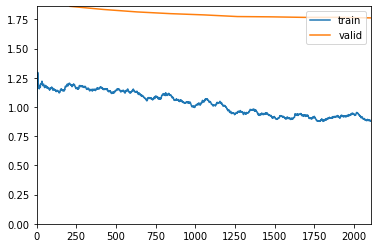

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet26.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet26')

### SE-ResNet50

In [ ]:
def seresnet50(pretrained=False):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
seresnet50()

Sequential(
  (init_block): ResInitBlock(
    (conv): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (unit1): SEResUnit(
      (body): ResBottleneck(
        (conv1): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv3): ConvBlo

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
28,410,096 total parameters.
2,424,192 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.3182567499825382e-06)

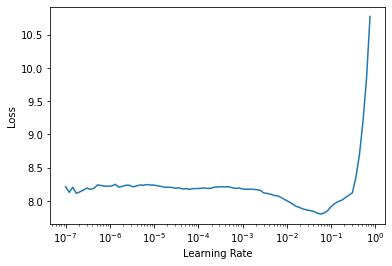

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.356462,3.840909,0.224225,0.451994,01:11
1,3.845643,3.036343,0.338848,0.615953,01:11
2,2.965948,2.479146,0.428951,0.702511,01:11
3,2.482656,2.202427,0.475332,0.756278,01:11
4,2.107205,2.055359,0.507238,0.773708,01:11
5,1.680195,1.883790,0.547710,0.809158,01:11
6,1.290859,1.739351,0.581979,0.833973,01:11
7,0.987598,1.643471,0.602954,0.847267,01:12
8,0.760266,1.618479,0.608863,0.850222,01:12
9,0.617128,1.603362,0.611521,0.851403,01:12


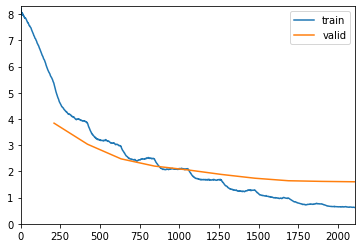

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet50.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet50')

Unfreezing model body
28,410,096 total parameters.
28,410,096 training parameters.


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.5848931980144698e-06)

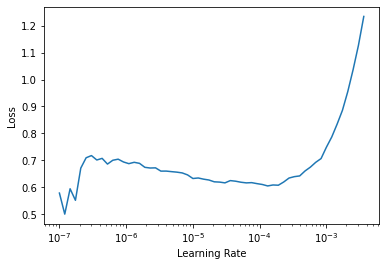

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.646716,1.601516,0.611521,0.854062,01:25
1,0.631903,1.586906,0.614771,0.856721,01:25
2,0.632494,1.586205,0.614771,0.858493,01:25
3,0.586187,1.575890,0.617725,0.860266,01:25
4,0.534653,1.579053,0.618316,0.860266,01:25
5,0.511894,1.561617,0.623634,0.863515,01:26
6,0.476855,1.563055,0.625111,0.865583,01:25
7,0.460504,1.566020,0.623338,0.864993,01:25
8,0.437246,1.566127,0.620975,0.863220,01:26
9,0.446590,1.558600,0.624225,0.865879,01:26


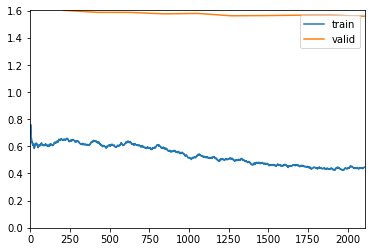

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet50.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet50')

### SE-ResNet50b

In [ ]:
def seresnet50b(pretrained=False):
    return ptcv_get_model("seresnet50b", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50b',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
28,410,096 total parameters.
2,424,192 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

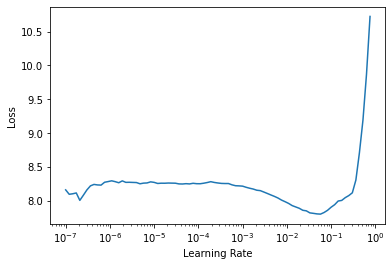

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.287704,3.791231,0.228951,0.462629,01:11
1,3.767697,2.985386,0.351551,0.617134,01:11
2,2.910197,2.414559,0.425702,0.719646,01:11
3,2.451332,2.193429,0.463516,0.759232,01:11
4,2.085236,2.020009,0.502806,0.791137,01:11
5,1.632450,1.854848,0.547415,0.810044,01:11
6,1.266766,1.693202,0.584047,0.838405,01:11
7,0.934938,1.627107,0.615362,0.847267,01:11
8,0.719719,1.612075,0.605908,0.854357,01:11
9,0.603394,1.595312,0.608863,0.858789,01:11


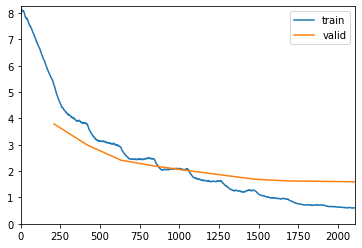

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet50b.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet50b')

Unfreezing model body
28,410,096 total parameters.
28,410,096 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=4.786300905834651e-06)

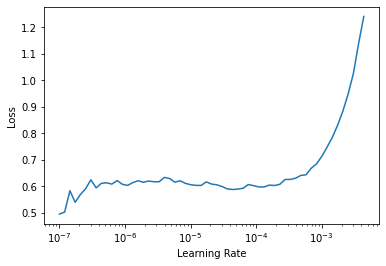

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.626150,1.592844,0.615362,0.857312,01:27
1,0.580884,1.588811,0.613294,0.856130,01:27
2,0.587237,1.573123,0.617134,0.859380,01:27
3,0.557235,1.563152,0.619202,0.860857,01:27
4,0.522514,1.558434,0.622157,0.863220,01:27
5,0.478690,1.549033,0.624225,0.861448,01:27
6,0.458225,1.553625,0.624225,0.862629,01:27
7,0.447686,1.555233,0.626588,0.862334,01:27
8,0.443424,1.553688,0.625997,0.864402,01:27
9,0.427252,1.547328,0.623043,0.864402,01:28


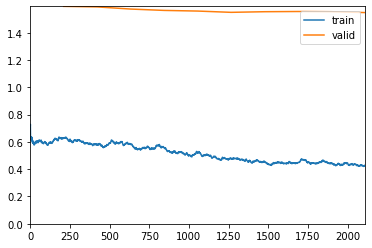

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet50b.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet50b')

### SE-ResNet101

In [ ]:
def seresnet101(pretrained=False):
    return ptcv_get_model("seresnet101", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet101',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
49,648,944 total parameters.
2,476,416 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.007585775572806597)

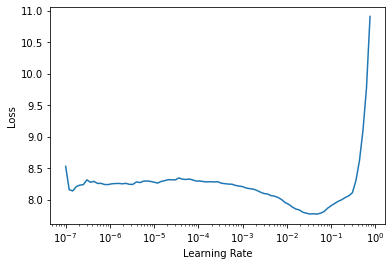

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.035882,3.549361,0.260857,0.507533,01:40
1,3.705876,2.910195,0.366617,0.640768,01:40
2,2.806182,2.396639,0.448449,0.725849,01:40
3,2.388973,2.169567,0.482127,0.758641,01:40
4,2.006859,1.961092,0.528213,0.794092,01:40
5,1.608404,1.832162,0.555096,0.819498,01:40
6,1.191245,1.736462,0.571640,0.834564,01:40
7,0.883912,1.654328,0.601773,0.848154,01:40
8,0.679154,1.615485,0.617725,0.854062,01:39
9,0.551220,1.605679,0.621270,0.855539,01:40


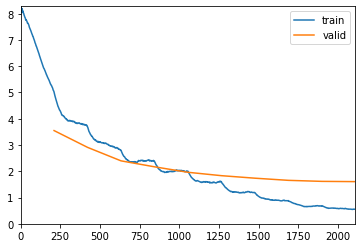

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet101.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet101')

Unfreezing model body
49,648,944 total parameters.
49,648,944 training parameters.


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=9.12010818865383e-07)

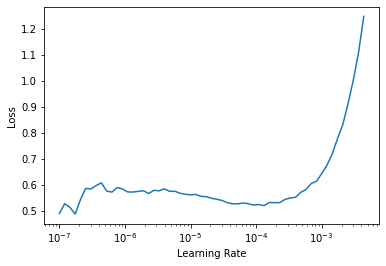

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.567001,1.602644,0.620384,0.857607,02:10
1,0.547625,1.596869,0.622747,0.856425,02:10
2,0.544810,1.579722,0.623929,0.859970,02:11
3,0.537398,1.590386,0.625997,0.856721,02:11
4,0.466374,1.584614,0.629838,0.858493,02:11
5,0.450297,1.566402,0.636632,0.861152,02:11
6,0.414108,1.574999,0.631610,0.862038,02:11
7,0.417284,1.574310,0.632496,0.864402,02:11
8,0.395919,1.572766,0.631019,0.864402,02:11
9,0.379928,1.571079,0.633678,0.865879,02:11


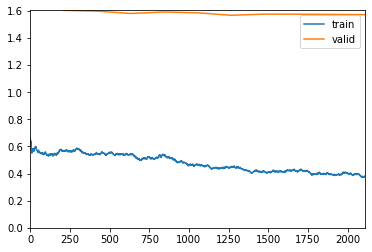

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet101.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet101')

### SE-ResNet101b

In [ ]:
def seresnet101b(pretrained=False):
    return ptcv_get_model("seresnet101b", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet101b',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
49,648,944 total parameters.
2,476,416 training parameters.


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.007585775572806597)

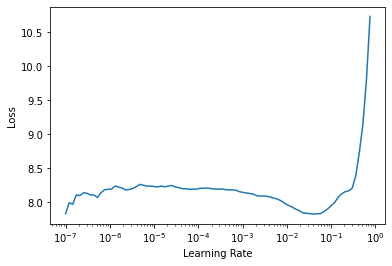

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.250927,3.764803,0.233973,0.468242,01:41
1,3.745136,2.979804,0.345643,0.623043,01:41
2,2.859845,2.472285,0.442541,0.709601,01:41
3,2.416728,2.136301,0.487740,0.761300,01:41
4,2.027601,1.974134,0.522009,0.789956,01:41
5,1.605264,1.851569,0.540916,0.816839,01:41
6,1.231358,1.688389,0.581388,0.836337,01:41
7,0.896484,1.624976,0.600886,0.852585,01:41
8,0.695693,1.583565,0.614476,0.857903,01:41
9,0.588950,1.571824,0.615657,0.857607,01:41


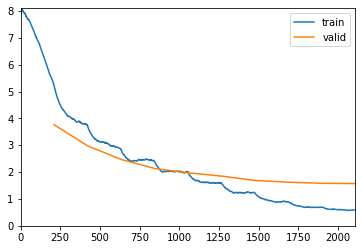

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet101b.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet101b')

Unfreezing model body
49,648,944 total parameters.
49,648,944 training parameters.


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=7.585775847473997e-07)

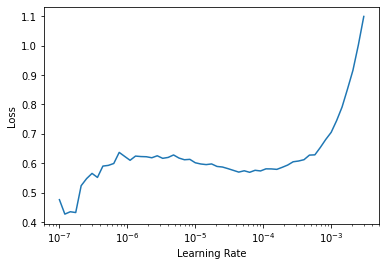

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.586118,1.574893,0.617430,0.858198,02:12
1,0.560574,1.567574,0.617430,0.861743,02:12
2,0.545423,1.557205,0.623929,0.861448,02:12
3,0.527587,1.547214,0.625997,0.864106,02:12
4,0.461606,1.557585,0.625406,0.861448,02:12
5,0.438608,1.552906,0.625702,0.862925,02:12
6,0.408206,1.546982,0.628951,0.864993,02:11
7,0.394630,1.541739,0.628951,0.866470,02:12
8,0.383168,1.541229,0.627770,0.866765,02:11
9,0.370466,1.537111,0.629247,0.867651,02:11


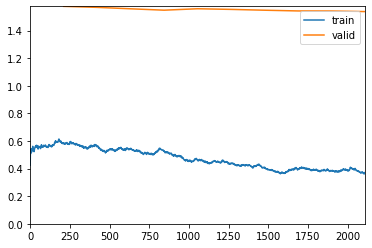

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet101b.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet101b')

### SE-ResNet152 - bs62

In [ ]:
def seresnet152(pretrained=False):
    return ptcv_get_model("seresnet152", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet152',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs=62
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
67,143,920 total parameters.
2,522,496 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.009120108559727669)

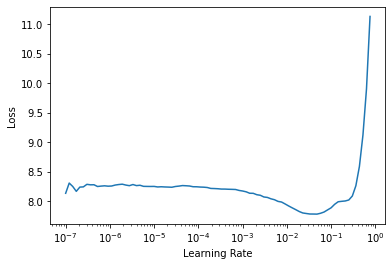

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.042800,3.580207,0.263811,0.492762,02:15
1,3.691800,2.996382,0.346824,0.619202,02:15
2,2.812813,2.412414,0.440768,0.719646,02:15
3,2.392697,2.096848,0.486854,0.777253,02:15
4,1.972504,2.015759,0.516100,0.790251,02:14
5,1.575867,1.849737,0.557164,0.812999,02:15
6,1.200624,1.712421,0.590251,0.834860,02:15
7,0.864189,1.651126,0.604431,0.848154,02:15
8,0.668104,1.628325,0.613885,0.858198,02:15
9,0.532495,1.610757,0.622747,0.858198,02:16


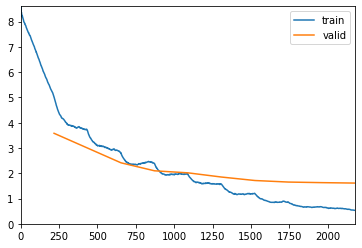

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet152-bs62.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet152-bs62')

Unfreezing model body
67,143,920 total parameters.
67,143,920 training parameters.


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=9.12010818865383e-07)

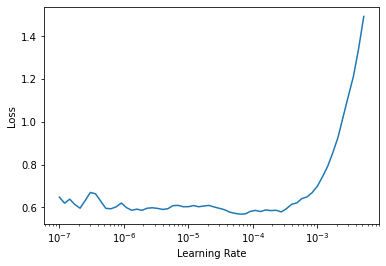

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.564668,1.615867,0.618612,0.859675,03:01
1,0.524782,1.604799,0.622452,0.861448,03:00
2,0.527668,1.595869,0.619793,0.861448,03:00
3,0.496065,1.601053,0.618021,0.864993,03:01
4,0.456900,1.595281,0.625702,0.862629,03:01
5,0.415209,1.578261,0.625111,0.863811,03:01
6,0.401605,1.581027,0.624225,0.867947,03:01
7,0.380872,1.582532,0.627179,0.864402,03:01
8,0.366610,1.581791,0.628065,0.867356,03:02
9,0.360965,1.572616,0.632496,0.868538,03:01


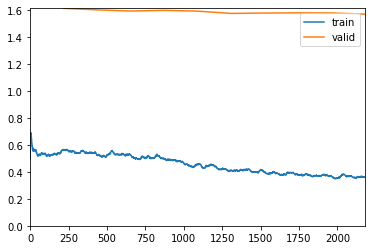

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet152-bs62.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet152-bs62')

### SE-ResNet50 - Manual Head

The results are marginally different, due to a source of randomness in the preparation of the model.

In [ ]:
def seresnet50(pretrained=False):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
# Manually Build Head
custom_head = nn.Sequential(AdaptiveConcatPool2d(), 
                            Flatten(), 
                            nn.BatchNorm1d(4096), 
                            nn.Dropout(p=0.25, inplace=False),
                            nn.Linear(in_features=4096, out_features=512, bias=False), 
                            nn.ReLU(inplace=True),
                            nn.BatchNorm1d(512), 
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=512, out_features=517, bias=False))

In [ ]:
# Create a learner
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           custom_head = custom_head,
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
28,410,096 total parameters.
2,424,192 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.009120108559727669)

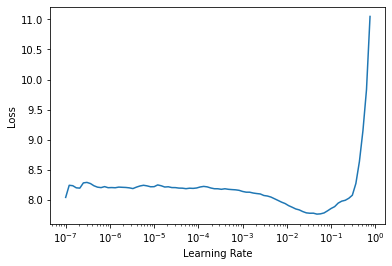

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.361674,3.888216,0.228951,0.451994,01:11
1,3.839684,3.065328,0.328213,0.610635,01:10
2,2.898010,2.500524,0.421270,0.702216,01:10
3,2.482582,2.214073,0.472969,0.757755,01:10
4,2.079001,2.009237,0.504874,0.791728,01:09
5,1.696025,1.850995,0.555096,0.813885,01:09
6,1.311480,1.723384,0.582866,0.835746,01:09
7,0.968270,1.650970,0.597046,0.844313,01:09
8,0.766301,1.623140,0.605022,0.850812,01:11
9,0.628729,1.608324,0.608863,0.851108,01:10


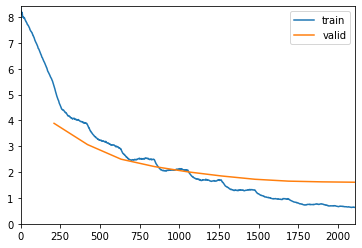

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnet50-ch.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnet50-ch')

Unfreezing model body
28,410,096 total parameters.
28,410,096 training parameters.


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=6.918309736647643e-06)

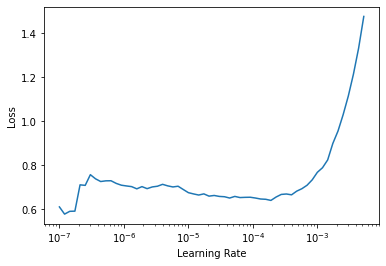

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.651437,1.612241,0.612112,0.851994,01:24
1,0.637783,1.595979,0.614476,0.853767,01:25
2,0.613615,1.592138,0.615953,0.854948,01:25
3,0.580827,1.578563,0.620384,0.858789,01:24
4,0.548936,1.582166,0.618316,0.859084,01:25
5,0.513210,1.574467,0.622747,0.857607,01:25
6,0.478993,1.570866,0.629247,0.860266,01:25
7,0.445779,1.565927,0.627179,0.862038,01:25
8,0.460655,1.561267,0.629247,0.862629,01:24
9,0.460425,1.560897,0.630133,0.860266,01:24


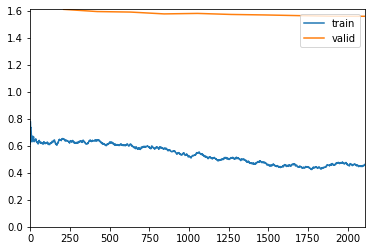

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnet50-ch.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnet50-ch')

### SE-ResNet50 - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def seresnet50_customsplit(pretrained=True):
    return ptcv_get_model("seresnet50", pretrained=pretrained).features

In [ ]:
# Recall we want to cut at -2, and split at (2) in the arch_summary, we define
def _seresnet50_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[se_resnet50_customsplit] = {'cut': -1, 
                           'split': _seresnet50_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
28,410,096 total parameters.
28,410,096 training parameters.
---------1 Groups Frozen--------
28,410,096 total parameters.
26,816,640 training parameters.
---------2 Groups Frozen--------
28,410,096 total parameters.
2,424,192 training parameters.
---------3 Groups Frozen--------
28,410,096 total parameters.
62,336 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
28,410,096 total parameters.
2,424,192 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.3182567499825382e-06)

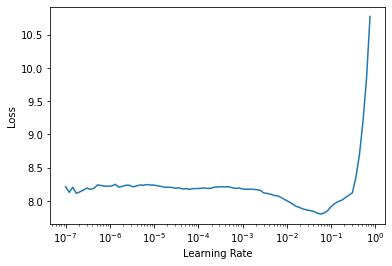

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.356462,3.840909,0.224225,0.451994,01:10
1,3.845643,3.036343,0.338848,0.615953,01:11
2,2.965948,2.479146,0.428951,0.702511,01:11
3,2.482656,2.202427,0.475332,0.756278,01:11
4,2.107205,2.055359,0.507238,0.773708,01:11
5,1.680195,1.883790,0.547710,0.809158,01:10
6,1.290859,1.739351,0.581979,0.833973,01:10
7,0.987598,1.643471,0.602954,0.847267,01:10
8,0.760266,1.618479,0.608863,0.850222,01:10
9,0.617128,1.603362,0.611521,0.851403,01:10


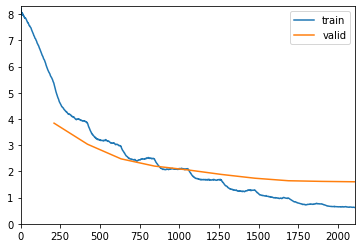

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchcv-seresnet50-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchcv-seresnet50-customsplit')

Unfreezing model body
28,410,096 total parameters.
28,410,096 training parameters.


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.5848931980144698e-06)

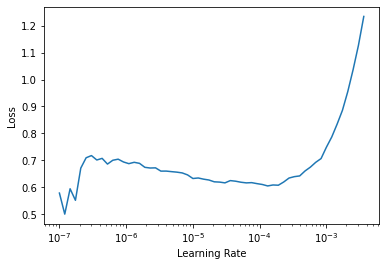

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.652912,1.599262,0.611226,0.853767,01:24
1,0.665910,1.601507,0.614476,0.854062,01:24
2,0.670121,1.601694,0.617134,0.857312,01:25
3,0.589590,1.577170,0.624520,0.859675,01:24
4,0.508951,1.580634,0.623338,0.858789,01:25
5,0.452752,1.554232,0.626588,0.866174,01:25
6,0.385829,1.550664,0.631610,0.863811,01:25
7,0.353015,1.548502,0.632201,0.867356,01:25
8,0.319961,1.547997,0.633383,0.868242,01:25
9,0.316782,1.541065,0.634564,0.867061,01:25


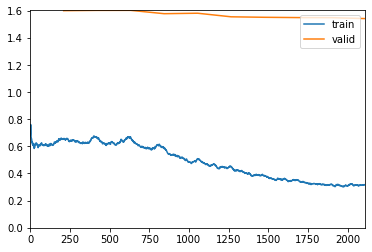

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchcv-seresnet50-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchcv-seresnet50-customsplit')

### SE-ResNet50b - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def seresnet50b_customsplit(pretrained=True):
    return ptcv_get_model("seresnet50b", pretrained=pretrained).features

In [ ]:
# Recall we want to cut at -2, and split at (2) in the arch_summary, we define
def _seresnet50b_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[seresnet50b_customsplit] = {'cut': -1, 
                           'split': _seresnet50b_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet50b_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
28,410,096 total parameters.
28,410,096 training parameters.
---------1 Groups Frozen--------
28,410,096 total parameters.
26,816,640 training parameters.
---------2 Groups Frozen--------
28,410,096 total parameters.
2,424,192 training parameters.
---------3 Groups Frozen--------
28,410,096 total parameters.
62,336 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
28,410,096 total parameters.
2,424,192 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

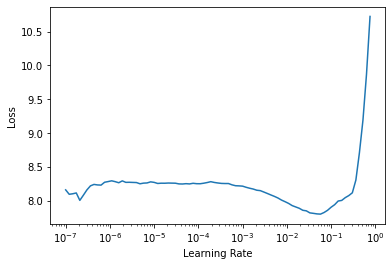

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.287704,3.791231,0.228951,0.462629,01:13
1,3.767697,2.985386,0.351551,0.617134,01:12
2,2.910197,2.414559,0.425702,0.719646,01:11
3,2.451332,2.193429,0.463516,0.759232,01:12
4,2.085236,2.020009,0.502806,0.791137,01:13
5,1.632450,1.854848,0.547415,0.810044,01:13
6,1.266766,1.693202,0.584047,0.838405,01:13
7,0.934938,1.627107,0.615362,0.847267,01:12
8,0.719719,1.612075,0.605908,0.854357,01:12
9,0.603394,1.595312,0.608863,0.858789,01:12


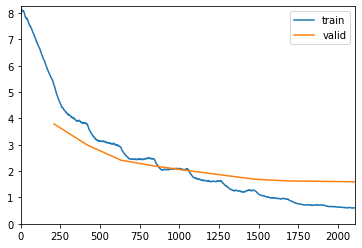

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchcv-seresnet50b-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchcv-seresnet50b-customsplit')

Unfreezing model body
28,410,096 total parameters.
28,410,096 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=4.786300905834651e-06)

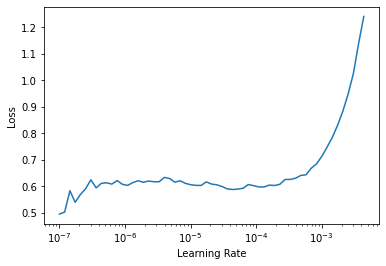

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.629500,1.589646,0.617134,0.854357,01:27
1,0.609160,1.598787,0.612999,0.854357,01:27
2,0.629880,1.592543,0.610044,0.856721,01:27
3,0.567431,1.557522,0.619793,0.860561,01:27
4,0.500481,1.533675,0.625997,0.866765,01:27
5,0.436123,1.527717,0.629542,0.866765,01:27
6,0.387875,1.540180,0.630724,0.864993,01:27
7,0.354952,1.537749,0.632496,0.869719,01:27
8,0.338360,1.533429,0.632201,0.868538,01:27
9,0.320895,1.524798,0.631905,0.870310,01:27


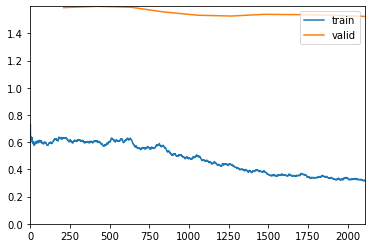

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchcv-seresnet50b-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchcv-seresnet50b-customsplit')

### SE-ResNet101 - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def seresnet101_customsplit(pretrained=True):
    return ptcv_get_model("seresnet101", pretrained=pretrained).features

In [ ]:
# Recall we want to cut at -2, and split at (2) in the arch_summary, we define
def _seresnet101_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[seresnet101_customsplit] = {'cut': -1, 
                           'split': _seresnet101_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet101_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
49,648,944 total parameters.
49,648,944 training parameters.
---------1 Groups Frozen--------
49,648,944 total parameters.
48,055,488 training parameters.
---------2 Groups Frozen--------
49,648,944 total parameters.
2,476,416 training parameters.
---------3 Groups Frozen--------
49,648,944 total parameters.
114,560 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
49,648,944 total parameters.
2,476,416 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.007585775572806597)

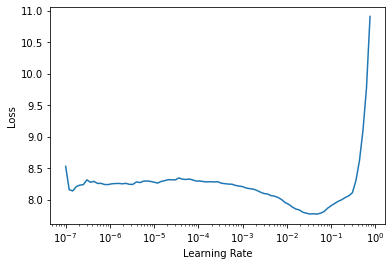

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.035882,3.549361,0.260857,0.507533,01:40
1,3.705876,2.910195,0.366617,0.640768,01:40
2,2.806182,2.396639,0.448449,0.725849,01:39
3,2.388973,2.169567,0.482127,0.758641,01:40
4,2.006859,1.961092,0.528213,0.794092,01:40
5,1.608404,1.832162,0.555096,0.819498,01:40
6,1.191245,1.736462,0.571640,0.834564,01:40
7,0.883912,1.654328,0.601773,0.848154,01:40
8,0.679154,1.615485,0.617725,0.854062,01:40
9,0.551220,1.605679,0.621270,0.855539,01:40


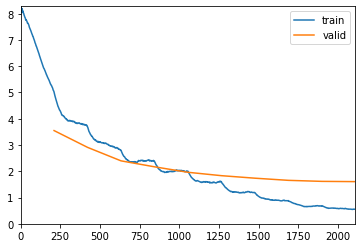

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchcv-seresnet101-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchcv-seresnet101-customsplit')

Unfreezing model body
49,648,944 total parameters.
49,648,944 training parameters.


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=9.12010818865383e-07)

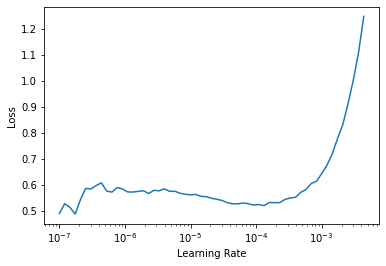

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.569839,1.599272,0.618612,0.857312,02:10
1,0.581766,1.613396,0.622157,0.851994,02:11
2,0.580225,1.607008,0.621270,0.855539,02:11
3,0.542699,1.608465,0.623043,0.854653,02:11
4,0.450669,1.589129,0.630724,0.859084,02:11
5,0.394295,1.562997,0.631905,0.861448,02:11
6,0.345022,1.571099,0.635746,0.863811,02:11
7,0.324005,1.567788,0.637223,0.866174,02:11
8,0.295147,1.564428,0.640177,0.863811,02:10
9,0.280007,1.562327,0.638109,0.865288,02:11


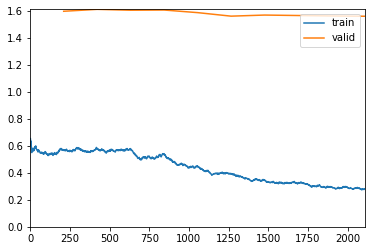

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchcv-seresnet101-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchcv-seresnet101-customsplit')

### SE-ResNet101b - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def seresnet101b_customsplit(pretrained=True):
    return ptcv_get_model("seresnet101b", pretrained=pretrained).features

In [ ]:
# Recall we want to cut at -2, and split at (2) in the arch_summary, we define
def _seresnet101b_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[seresnet101b_customsplit] = {'cut': -1, 
                           'split': _seresnet101b_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnet101b_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
49,648,944 total parameters.
49,648,944 training parameters.
---------1 Groups Frozen--------
49,648,944 total parameters.
48,055,488 training parameters.
---------2 Groups Frozen--------
49,648,944 total parameters.
2,476,416 training parameters.
---------3 Groups Frozen--------
49,648,944 total parameters.
114,560 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
49,648,944 total parameters.
2,476,416 training parameters.


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.007585775572806597)

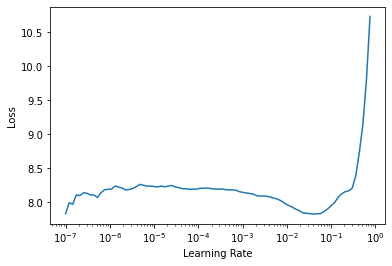

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.250927,3.764803,0.233973,0.468242,01:42
1,3.745136,2.979804,0.345643,0.623043,01:42
2,2.859845,2.472285,0.442541,0.709601,01:42
3,2.416728,2.136301,0.487740,0.761300,01:42
4,2.027601,1.974134,0.522009,0.789956,01:42
5,1.605264,1.851569,0.540916,0.816839,01:42
6,1.231358,1.688389,0.581388,0.836337,01:42
7,0.896484,1.624976,0.600886,0.852585,01:42
8,0.695693,1.583565,0.614476,0.857903,01:42
9,0.588950,1.571824,0.615657,0.857607,01:42


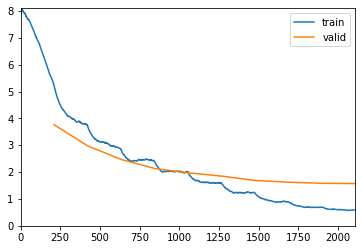

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchcv-seresnet101b-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchcv-seresnet101b-customsplit')

Unfreezing model body
49,648,944 total parameters.
49,648,944 training parameters.


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=7.585775847473997e-07)

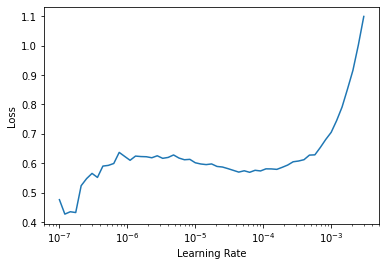

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.590239,1.574350,0.618021,0.857312,02:13
1,0.592810,1.592952,0.617430,0.857312,02:14
2,0.594687,1.573824,0.621566,0.858198,02:13
3,0.544928,1.559538,0.624520,0.863515,02:13
4,0.454296,1.550308,0.626883,0.864106,02:14
5,0.398324,1.539617,0.635155,0.867356,02:14
6,0.343336,1.524707,0.640177,0.866765,02:14
7,0.295220,1.514912,0.640768,0.872378,02:14
8,0.283813,1.512092,0.640473,0.869424,02:14
9,0.268039,1.505168,0.643427,0.871787,02:14


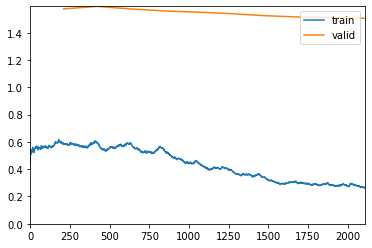

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchcv-seresnet101b-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchcv-seresnet101b-customsplit')

## ResNeXt

### resnext50_32x4d

In [ ]:
def resnext50_32x4d(pretrained=True):
    return ptcv_get_model("resnext50_32x4d", pretrained=pretrained).features

In [ ]:
resnext50_32x4d()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'resnext50_32x4d',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
25,350,976 total parameters.
2,439,296 training parameters.


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.009120108559727669)

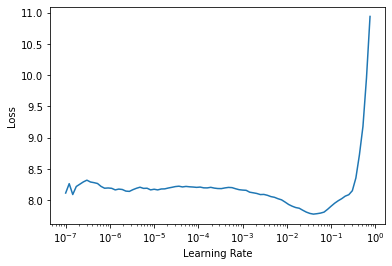

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.290440,3.827068,0.225997,0.457903,01:14
1,3.854507,3.084922,0.334417,0.602659,01:14
2,3.005838,2.606471,0.415657,0.689513,01:13
3,2.513468,2.254143,0.444609,0.753028,01:14
4,2.134535,2.079967,0.503397,0.780502,01:14
5,1.698683,1.937284,0.535894,0.801773,01:14
6,1.332011,1.754937,0.575776,0.832201,01:14
7,0.978272,1.672054,0.606499,0.846381,01:14
8,0.771782,1.648078,0.614771,0.849631,01:14
9,0.616559,1.634085,0.612112,0.851108,01:14


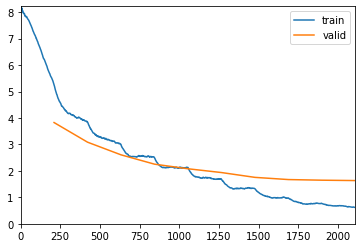

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-resnext50_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-resnext50_32x4d')

Unfreezing model body
25,350,976 total parameters.
25,350,976 training parameters.


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=7.585775847473997e-07)

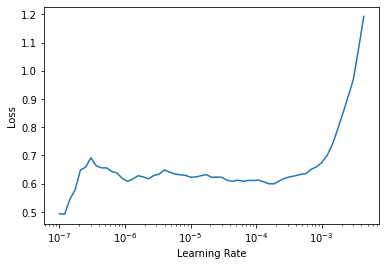

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.646954,1.641841,0.615953,0.851994,01:34
1,0.614194,1.621900,0.618907,0.851994,01:35
2,0.614033,1.611719,0.621270,0.859380,01:35
3,0.581862,1.612019,0.615953,0.859380,01:35
4,0.523900,1.613763,0.625997,0.859084,01:35
5,0.482707,1.597146,0.626883,0.859380,01:34
6,0.469629,1.596502,0.627474,0.860561,01:35
7,0.450866,1.596709,0.629542,0.858789,01:35
8,0.442622,1.596998,0.627770,0.864106,01:35
9,0.443464,1.592410,0.631315,0.863220,01:35


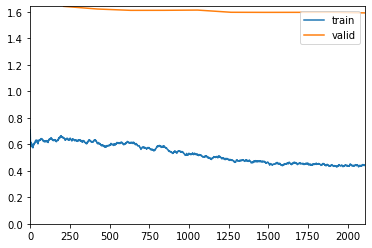

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-resnext50_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-resnext50_32x4d')

### resnext50_32x4d - Custom Split


In [ ]:
def resnext50_32x4d_customsplit(pretrained=True):
    return ptcv_get_model("resnext50_32x4d", pretrained=pretrained).features

In [ ]:
# All pytorchCV models are cut at -1, split should achieve around 5% of the model parameters in the first group
def _resnext50_32x4d_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[resnext50_32x4d_customsplit] = {'cut': -1, 
                           'split': _resnext50_32x4d_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'resnext50_32x4d_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 29  layers (total: 33)
(2) Sequential  : 38  layers (total: 71)
(3) Sequential  : 56  layers (total: 127)
(4) Sequential  : 29  layers (total: 156)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
25,350,976 total parameters.
25,350,976 training parameters.
---------1 Groups Frozen--------
25,350,976 total parameters.
23,951,488 training parameters.
---------2 Groups Frozen--------
25,350,976 total parameters.
2,439,296 training parameters.
---------3 Groups Frozen--------
25,350,976 total parameters.
77,440 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
25,350,976 total parameters.
2,439,296 training parameters.


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.009120108559727669)

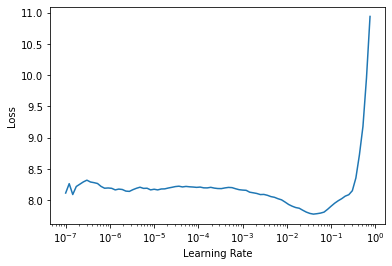

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.290440,3.827068,0.225997,0.457903,01:14
1,3.854507,3.084922,0.334417,0.602659,01:13
2,3.005838,2.606471,0.415657,0.689513,01:14
3,2.513468,2.254143,0.444609,0.753028,01:14
4,2.134535,2.079967,0.503397,0.780502,01:14
5,1.698683,1.937284,0.535894,0.801773,01:13
6,1.332011,1.754937,0.575776,0.832201,01:13
7,0.978272,1.672054,0.606499,0.846381,01:13
8,0.771782,1.648078,0.614771,0.849631,01:14
9,0.616559,1.634085,0.612112,0.851108,01:13


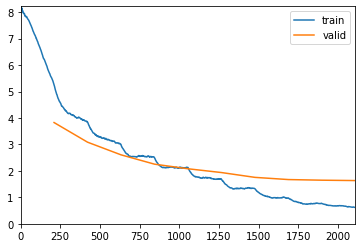

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-resnext50_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-resnext50_32x4d-cs')

Unfreezing model body
25,350,976 total parameters.
25,350,976 training parameters.


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=7.585775847473997e-07)

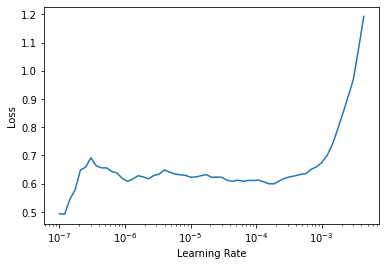

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.649885,1.638733,0.613589,0.854357,01:34
1,0.630548,1.621832,0.614180,0.853767,01:34
2,0.627292,1.617903,0.622747,0.856130,01:34
3,0.563737,1.594846,0.621566,0.865583,01:34
4,0.475730,1.586858,0.626588,0.865583,01:34
5,0.406538,1.580853,0.628065,0.867947,01:34
6,0.376099,1.571920,0.629247,0.867947,01:34
7,0.335254,1.568627,0.630724,0.869424,01:34
8,0.316511,1.568199,0.631610,0.871787,01:34
9,0.307874,1.563215,0.633087,0.869719,01:34


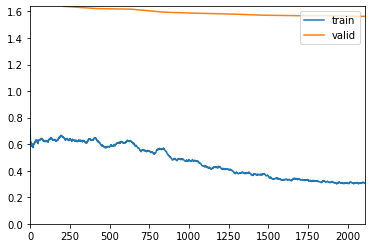

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-resnext50_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-resnext50_32x4d-cs')

### resnext101_32x4d

In [ ]:
def resnext101_32x4d(pretrained=True):
    return ptcv_get_model("resnext101_32x4d", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'resnext101_32x4d',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
44,499,776 total parameters.
2,508,928 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

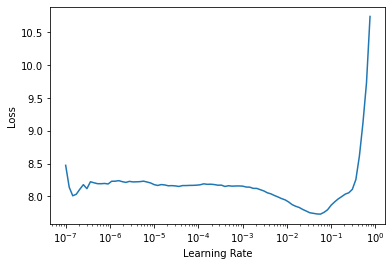

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.307451,3.751055,0.237518,0.472969,01:50
1,3.818484,3.079508,0.328804,0.607090,01:49
2,2.901412,2.458669,0.431610,0.712555,01:49
3,2.464231,2.204840,0.477696,0.745347,01:49
4,2.021859,2.000387,0.515510,0.793796,01:49
5,1.614543,1.860548,0.553619,0.807681,01:49
6,1.237236,1.743317,0.573117,0.832201,01:49
7,0.886356,1.668550,0.610340,0.842541,01:49
8,0.687482,1.655971,0.606795,0.846086,01:49
9,0.577519,1.632743,0.613294,0.847858,01:49


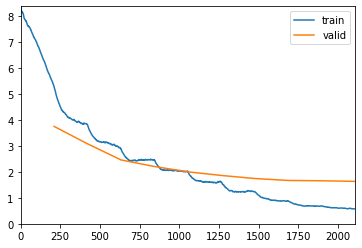

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-resnext101_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-resnext101_32x4d')

Unfreezing model body
44,499,776 total parameters.
44,499,776 training parameters.


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=9.999999747378752e-06)

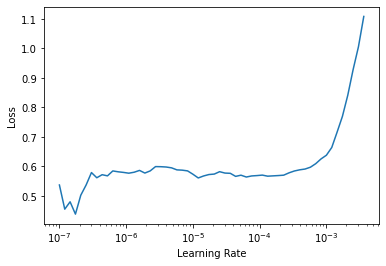

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.578891,1.637380,0.615066,0.851108,02:27
1,0.564294,1.617625,0.617725,0.849926,02:27
2,0.543042,1.599926,0.620384,0.853176,02:27
3,0.494963,1.613934,0.619793,0.855244,02:27
4,0.470457,1.619147,0.622157,0.854357,02:27
5,0.430412,1.596595,0.625702,0.859084,02:27
6,0.384018,1.599123,0.625997,0.859380,02:27
7,0.384256,1.594551,0.628360,0.859084,02:27
8,0.373948,1.588808,0.629247,0.859380,02:27
9,0.367966,1.593271,0.633678,0.857903,02:27


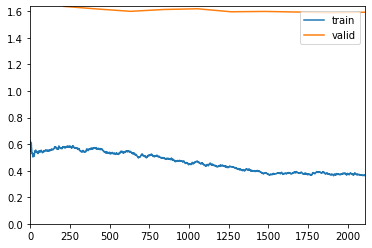

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-resnext101_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-resnext101_32x4d')

### resnext101_32x4d - Custom Split


In [ ]:
def resnext101_32x4d_customsplit(pretrained=True):
    return ptcv_get_model("resnext101_32x4d", pretrained=pretrained).features

In [ ]:
# All pytorchCV models are cut at -1, split should achieve around 5% of the model parameters in the first group
def _resnext101_32x4d_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[resnext101_32x4d_customsplit] = {'cut': -1, 
                           'split': _resnext101_32x4d_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'resnext101_32x4d_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 29  layers (total: 33)
(2) Sequential  : 38  layers (total: 71)
(3) Sequential  : 209 layers (total: 280)
(4) Sequential  : 29  layers (total: 309)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
44,499,776 total parameters.
44,499,776 training parameters.
---------1 Groups Frozen--------
44,499,776 total parameters.
43,100,288 training parameters.
---------2 Groups Frozen--------
44,499,776 total parameters.
2,508,928 training parameters.
---------3 Groups Frozen--------
44,499,776 total parameters.
147,072 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
44,499,776 total parameters.
2,508,928 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

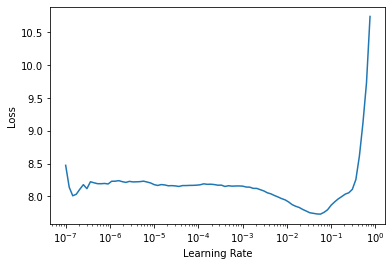

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.307451,3.751055,0.237518,0.472969,01:48
1,3.818484,3.079508,0.328804,0.607090,01:49
2,2.901412,2.458669,0.431610,0.712555,01:49
3,2.464231,2.204840,0.477696,0.745347,01:49
4,2.021859,2.000387,0.515510,0.793796,01:49
5,1.614543,1.860548,0.553619,0.807681,01:49
6,1.237236,1.743317,0.573117,0.832201,01:49
7,0.886356,1.668550,0.610340,0.842541,01:49
8,0.687482,1.655971,0.606795,0.846086,01:49
9,0.577519,1.632743,0.613294,0.847858,01:49


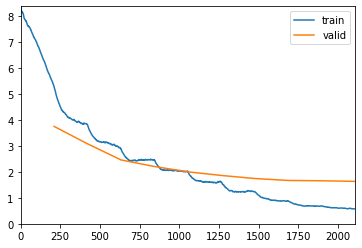

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-resnext101_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-resnext101_32x4d-cs')

Unfreezing model body
44,499,776 total parameters.
44,499,776 training parameters.


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=9.999999747378752e-06)

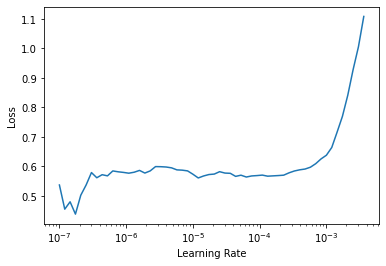

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.584799,1.631946,0.616839,0.851994,02:27
1,0.598567,1.625304,0.620679,0.852289,02:27
2,0.582785,1.607838,0.622747,0.855244,02:27
3,0.497071,1.632532,0.622157,0.853471,02:27
4,0.438759,1.620289,0.628656,0.854653,02:27
5,0.375027,1.601983,0.630133,0.864402,02:27
6,0.304261,1.588064,0.636632,0.861743,02:27
7,0.284619,1.576692,0.640177,0.864697,02:27
8,0.263514,1.571974,0.637518,0.864106,02:27
9,0.245623,1.579049,0.639882,0.865583,02:27


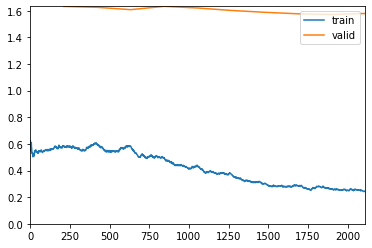

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-resnext101_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-resnext101_32x4d-cs')

## SE-ResNeXt

### seresnext50_32x4d

In [ ]:
def seresnext50_32x4d(pretrained=True):
    return ptcv_get_model("seresnext50_32x4d", pretrained=pretrained).features

In [ ]:
seresnext50_32x4d()

Sequential(
  (init_block): ResInitBlock(
    (conv): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (unit1): SEResNeXtUnit(
      (body): ResNeXtBottleneck(
        (conv1): ConvBlock(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )


In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnext50_32x4d',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
27,881,968 total parameters.
2,439,296 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.010964781977236271)

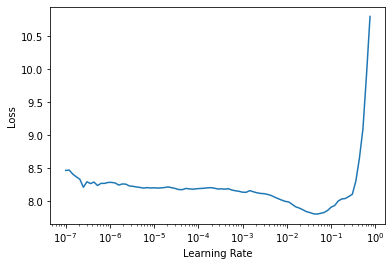

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.353081,3.778039,0.239291,0.465583,01:20
1,3.776161,2.900416,0.355687,0.631610,01:20
2,2.859338,2.388651,0.443722,0.719350,01:19
3,2.390012,2.161568,0.478582,0.762482,01:19
4,1.970417,1.976827,0.525554,0.795864,01:20
5,1.566589,1.849776,0.557164,0.817134,01:20
6,1.199175,1.719773,0.587297,0.834860,01:20
7,0.864344,1.660941,0.608863,0.842541,01:20
8,0.650756,1.636689,0.618907,0.849335,01:20
9,0.523777,1.622653,0.620384,0.852585,01:20


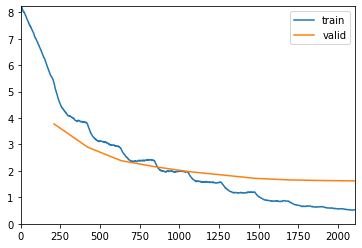

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnext50_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnext50_32x4d')

Unfreezing model body
27,881,968 total parameters.
27,881,968 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=9.12010818865383e-07)

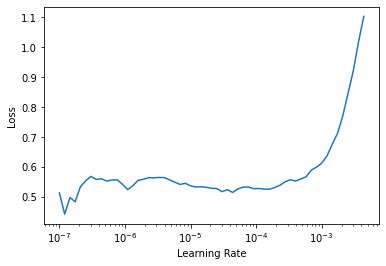

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.548098,1.628991,0.620679,0.849335,01:44
1,0.525027,1.612865,0.623338,0.854653,01:44
2,0.524562,1.607968,0.624815,0.854653,01:44
3,0.499202,1.601399,0.625406,0.854653,01:44
4,0.441696,1.603456,0.626883,0.854653,01:43
5,0.425535,1.602943,0.630133,0.856721,01:43
6,0.387771,1.594439,0.629838,0.856721,01:43
7,0.384389,1.594961,0.632496,0.858198,01:43
8,0.353815,1.596406,0.631315,0.859380,01:43
9,0.366615,1.590817,0.634564,0.859380,01:42


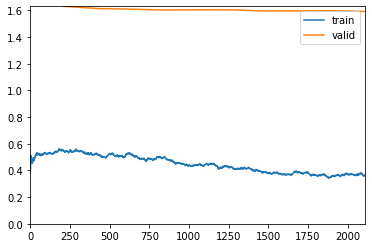

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnext50_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnext50_32x4d')

### seresnext50_32x4d - Custom Split

In [ ]:
def seresnext50_32x4d_customsplit(pretrained=True):
    return ptcv_get_model("seresnext50_32x4d", pretrained=pretrained).features

In [ ]:
# All pytorchCV models are cut at -1, split should achieve around 5% of the model parameters in the first group
def _seresnext50_32x4d_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[seresnext50_32x4d_customsplit] = {'cut': -1, 
                           'split': _seresnext50_32x4d_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnext50_32x4d_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 86  layers (total: 192)
(4) Sequential  : 44  layers (total: 236)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
27,881,968 total parameters.
27,881,968 training parameters.
---------1 Groups Frozen--------
27,881,968 total parameters.
26,323,840 training parameters.
---------2 Groups Frozen--------
27,881,968 total parameters.
2,439,296 training parameters.
---------3 Groups Frozen--------
27,881,968 total parameters.
77,440 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
27,881,968 total parameters.
2,439,296 training parameters.


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.010964781977236271)

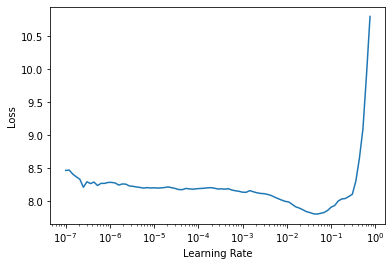

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.353081,3.778039,0.239291,0.465583,01:20
1,3.776161,2.900416,0.355687,0.631610,01:19
2,2.859338,2.388651,0.443722,0.719350,01:19
3,2.390012,2.161568,0.478582,0.762482,01:19
4,1.970417,1.976827,0.525554,0.795864,01:19
5,1.566589,1.849776,0.557164,0.817134,01:19
6,1.199175,1.719773,0.587297,0.834860,01:19
7,0.864344,1.660941,0.608863,0.842541,01:19
8,0.650756,1.636689,0.618907,0.849335,01:19
9,0.523777,1.622653,0.620384,0.852585,01:19


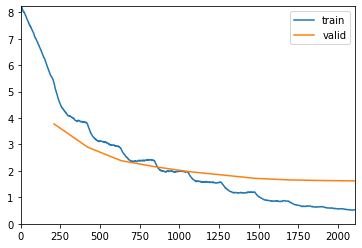

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnext50_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnext50_32x4d-cs')

Unfreezing model body
27,881,968 total parameters.
27,881,968 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=9.12010818865383e-07)

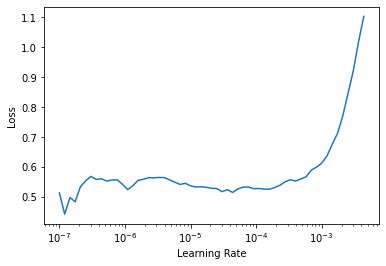

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.551019,1.626431,0.623634,0.851108,01:44
1,0.545102,1.615646,0.619793,0.854062,01:43
2,0.541299,1.609337,0.625997,0.861152,01:43
3,0.490263,1.584883,0.627179,0.864402,01:43
4,0.398513,1.581610,0.635746,0.862334,01:44
5,0.361607,1.593107,0.638996,0.862629,01:43
6,0.299177,1.582793,0.632496,0.861743,01:44
7,0.277490,1.575426,0.634269,0.864697,01:44
8,0.251262,1.575016,0.636041,0.864993,01:44
9,0.244386,1.567711,0.636337,0.867061,01:44


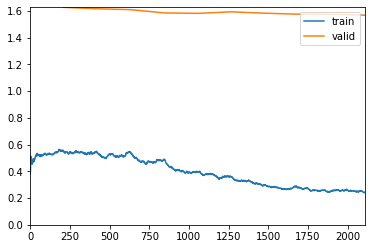

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnext50_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnext50_32x4d-cs')

### seresnext101_32x4d

In [ ]:
def seresnext101_32x4d(pretrained=True):
    return ptcv_get_model("seresnext101_32x4d", pretrained=pretrained).features

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnext101_32x4d',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
49,277,488 total parameters.
2,508,928 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

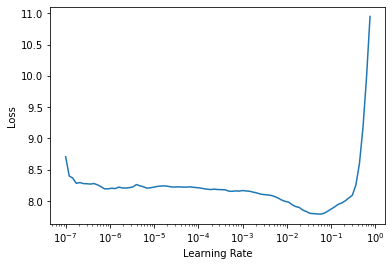

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.361666,3.842850,0.215953,0.459675,02:01
1,3.745556,2.974699,0.346529,0.623634,02:01
2,2.860595,2.370444,0.448744,0.730576,02:00
3,2.385577,2.108230,0.488626,0.767504,02:00
4,1.976743,1.939341,0.523191,0.803840,01:59
5,1.572900,1.773238,0.572230,0.823929,01:59
6,1.194555,1.680864,0.591433,0.844313,01:59
7,0.847960,1.592700,0.613294,0.859970,01:59
8,0.650313,1.568936,0.619793,0.859675,02:00
9,0.532804,1.562784,0.624520,0.861448,02:01


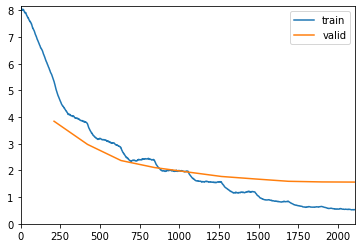

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnext101_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnext101_32x4d')

Unfreezing model body
49,277,488 total parameters.
49,277,488 training parameters.


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

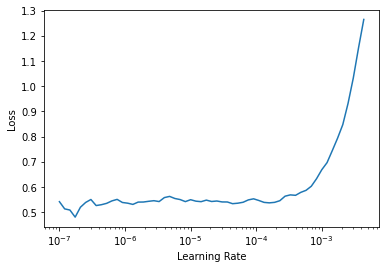

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.549590,1.562729,0.626883,0.862334,02:45
1,0.521807,1.548539,0.625997,0.863220,02:44
2,0.513431,1.536971,0.632496,0.868538,02:45
3,0.487458,1.536337,0.632792,0.866765,02:45
4,0.433246,1.530394,0.636632,0.871787,02:44
5,0.396584,1.525971,0.641064,0.872969,02:45
6,0.355624,1.514612,0.643131,0.873264,02:45
7,0.337520,1.515382,0.644018,0.873560,02:45
8,0.337054,1.514967,0.642541,0.875037,02:46
9,0.332217,1.512425,0.641950,0.871787,02:46


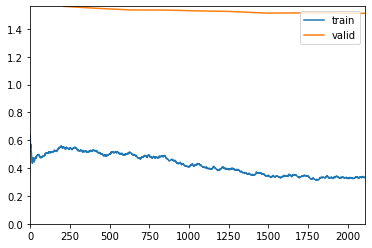

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnext101_32x4d.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnext101_32x4d')

### seresnext101_32x4d - Custom Split

In [ ]:
def seresnext101_32x4d_customsplit(pretrained=True):
    return ptcv_get_model("seresnext101_32x4d", pretrained=pretrained).features

In [ ]:
# All pytorchCV models are cut at -1, split should achieve around 5% of the model parameters in the first group
def _seresnext101_32x4d_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
model_meta[seresnext101_32x4d_customsplit] = {'cut': -1, 
                           'split': _seresnext101_32x4d_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'seresnext101_32x4d_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) ResInitBlock: 4   layers (total: 4)
(1) Sequential  : 44  layers (total: 48)
(2) Sequential  : 58  layers (total: 106)
(3) Sequential  : 324 layers (total: 430)
(4) Sequential  : 44  layers (total: 474)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
49,277,488 total parameters.
49,277,488 training parameters.
---------1 Groups Frozen--------
49,277,488 total parameters.
47,719,360 training parameters.
---------2 Groups Frozen--------
49,277,488 total parameters.
2,508,928 training parameters.
---------3 Groups Frozen--------
49,277,488 total parameters.
147,072 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
49,277,488 total parameters.
2,508,928 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

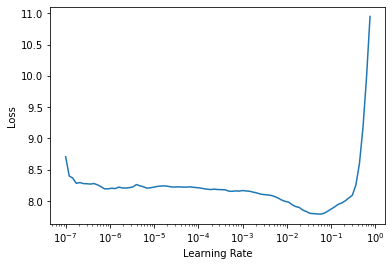

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.361666,3.842850,0.215953,0.459675,02:01
1,3.745556,2.974699,0.346529,0.623634,02:01
2,2.860595,2.370444,0.448744,0.730576,02:01
3,2.385577,2.108230,0.488626,0.767504,02:01
4,1.976743,1.939341,0.523191,0.803840,02:01
5,1.572900,1.773238,0.572230,0.823929,02:00
6,1.194555,1.680864,0.591433,0.844313,02:01
7,0.847960,1.592700,0.613294,0.859970,02:00
8,0.650313,1.568936,0.619793,0.859675,02:01
9,0.532804,1.562784,0.624520,0.861448,02:01


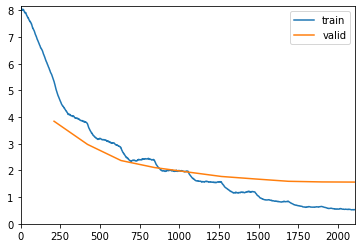

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-pytorchCV-seresnext101_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-pytorchCV-seresnext101_32x4d-cs')

Unfreezing model body
49,277,488 total parameters.
49,277,488 training parameters.


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

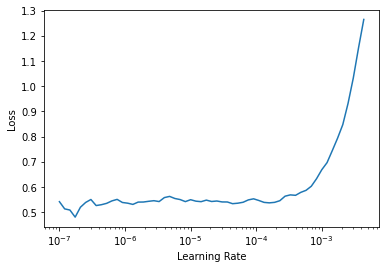

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.557044,1.562267,0.632496,0.861743,02:45
1,0.554602,1.558789,0.618316,0.863515,02:45
2,0.551056,1.549047,0.631315,0.864993,02:45
3,0.491243,1.539516,0.635451,0.868833,02:45
4,0.408697,1.534602,0.638405,0.873855,02:45
5,0.337255,1.523325,0.643427,0.874446,02:45
6,0.282209,1.509518,0.649631,0.874151,02:45
7,0.243184,1.495140,0.650517,0.876219,02:45
8,0.233833,1.496329,0.654653,0.879173,02:45
9,0.226786,1.493261,0.652585,0.882422,02:45


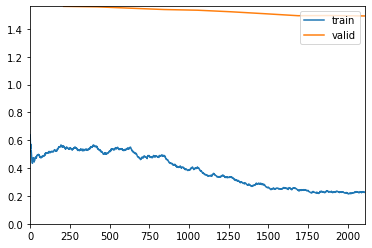

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-pytorchCV-seresnext101_32x4d-cs.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-pytorchCV-seresnext101_32x4d-cs')